<a href="https://colab.research.google.com/github/Phalguni-G/Code-Casa/blob/main/Stock_Prices_Predictor_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import yfinance as yf
import pandas as pd
import os
# calls the yahoo finance api to download daily stock and index prices

In [75]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

<Axes: xlabel='Date'>

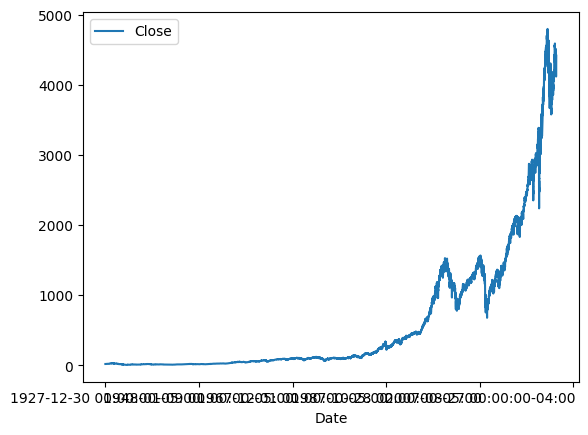

In [76]:
sp500.plot.line(y="Close", use_index=True)

In [77]:
del sp500['Dividends']
del sp500['Stock Splits']

In [78]:
sp500['Tomorrow'] = sp500['Close'].shift(-1)

In [79]:
sp500['Target'] = (sp500['Tomorrow'] > sp500['Close']).astype(int)
# Target is one when the price went up, and zero when it went down

In [80]:
sp500 = sp500.loc["1990-01-01":].copy()

In [81]:
# Training our machine learning model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state = 1)
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]
predictors = ['Close', 'Volume', 'Open', 'High', 'Low']
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [82]:
from sklearn.metrics import precision_score
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.4782608695652174

<Axes: xlabel='Date'>

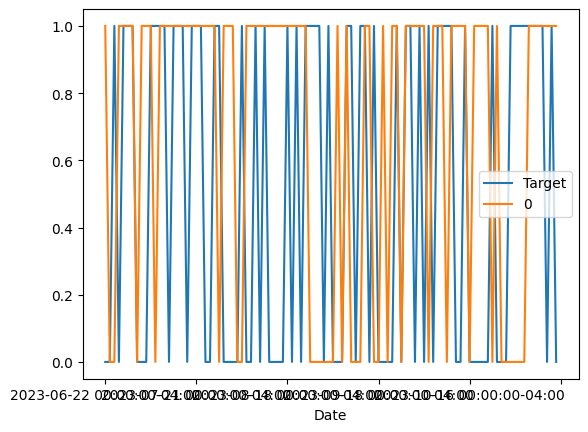

In [83]:
combined = pd.concat([test['Target'], preds], axis=1)
combined.plot()

In [84]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index, name='Predictions')
  combined = pd.concat([test['Target'], preds], axis =1)
  return combined

In [85]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [86]:
predictions = backtest(sp500, model, predictors)

In [87]:
predictions["Predictions"].value_counts()

0    3445
1    2587
Name: Predictions, dtype: int64

In [88]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5280247390800155

In [89]:
predictions['Target'].value_counts() / predictions.shape[0]

1    0.533654
0    0.466346
Name: Target, dtype: float64

In [97]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

<ipython-input-97-8d3c1d383c5e>:5: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Tred_1000', 'Tred_2', 'Tred_250', 'Tred_5', 'Tred_60'], dtype='object')
  rolling_averages = sp500.rolling(horizon).mean()
<ipython-input-97-8d3c1d383c5e>:11: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Tred_1000', 'Tred_2', 'Tred_250', 'Tred_5', 'Tred_60'], dtype='object')
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
<ipython-input-97-8d3c1d383c5e>:5: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns w

In [98]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [92]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [93]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [99]:
predictions = backtest(sp500, model, new_predictors)

In [100]:
predictions["Predictions"].value_counts()

0.0    3476
1.0     557
Name: Predictions, dtype: int64

In [101]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5368043087971275

In [102]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.539549
0    0.460451
Name: Target, dtype: float64

In [103]:
predictions

,Target,Predictions
Date,,
2007-11-05 00:00:00-05:00,1,1.0
2007-11-06 00:00:00-05:00,0,1.0
2007-11-07 00:00:00-05:00,0,1.0
2007-11-08 00:00:00-05:00,0,1.0
2007-11-09 00:00:00-05:00,0,1.0
...,...,...
2023-11-06 00:00:00-05:00,1,0.0
2023-11-07 00:00:00-05:00,1,0.0
2023-11-08 00:00:00-05:00,0,0.0
